#Sistema de Recomendação por Imagens Digitais

# 1. Instalação e imports
Instalamos as bibliotecas necessárias e importamos os módulos que serão usados no projeto de **Sistema de Recomendação por Imagem**.  

- `faiss-cpu` → biblioteca eficiente para **busca por similaridade de vetores**.  
- `numpy` → manipulação de arrays.  
- `matplotlib` → visualização de imagens e resultados.  
- `tensorflow` / `keras` → criação de embeddings e redes neurais.  
- `tensorflow_datasets` → carregamento de datasets prontos.

In [ ]:
# Instalação e imports
!pip install faiss-cpu -q
import numpy as np
import matplotlib.pyplot as plt
import faiss
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 39.6 MB/s eta 0:00:00


## 2. Carregar dataset Fashion-MNIST (70/15/15)
Usamos o **Fashion-MNIST** como dataset de exemplo para o sistema de recomendação.  

- Dividimos o dataset em **treino (70%)**, **validação (15%)** e **teste (15%)**.  
- Cada exemplo contém uma **imagem 28x28 em grayscale** e seu **rótulo** correspondente.  
- `class_names` → nomes das classes de roupas.

In [ ]:
# Carregar dataset Fashion-MNIST (70/15/15)
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "fashion_mnist",
    split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features["label"].names
print("Classes:", class_names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.M59MMN_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.M59MMN_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## 3. Pré-processamento
Preparação das imagens do **Fashion-MNIST** para alimentar a rede neural:  

- Redimensionamento para **96x96 pixels** (economia de memória).  
- Conversão de **grayscale → RGB** (3 canais) para compatibilidade com MobileNetV2.  
- Normalização para `[0,1]`.  
- Codificação dos rótulos em **one-hot**.  
- Criação de **batches** e shuffle para treino.

In [ ]:
# Pré-processamento
IMG_SIZE = 96  # reduzido para memória
BATCH_SIZE = 16

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.grayscale_to_rgb(image)
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, depth=10)

train_ds = ds_train.map(preprocess).batch(BATCH_SIZE).shuffle(1000)
val_ds   = ds_val.map(preprocess).batch(BATCH_SIZE)
test_ds  = ds_test.map(preprocess).batch(BATCH_SIZE)

## 4. Criar modelo MobileNetV2 leve (Functional API)
Construção de um modelo de classificação utilizando **Transfer Learning** com **MobileNetV2**:  

- `alpha=0.35` → versão leve do MobileNetV2, reduzindo parâmetros e consumo de memória.  
- `include_top=False` → remove a cabeça original da rede.  
- `GlobalAveragePooling2D` → reduz dimensionalidade mantendo informações relevantes.  
- Camada `Dense(128)` → embedding intermediário para extração de features.  
- Saída final `Dense(10, softmax)` → classificação em 10 classes do Fashion-MNIST.  
- Pesos da base congelados (`trainable=False`) para acelerar o treinamento.

In [ ]:

# Criar modelo MobileNetV2 leve (Functional API)
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=inputs,
    alpha=0.35  # versão leve
)
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu", name="embedding")(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


/tmp/ipython-input-2232818069.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 5. Treinamento rápido (3 épocas)
Treinamos rapidamente o modelo de classificação para gerar embeddings:  

- Apenas **3 épocas**, suficiente para extrair features representativas.  
- Usamos `train_ds` para treino e `val_ds` para validação.  

## 6. Modelo de embeddings
Criamos um **modelo derivado** a partir do classificador, que retorna apenas o vetor de **embedding** de 128 dimensões.  
Este modelo será usado para **buscar imagens similares** no índice FAISS.  

## 7. Criar index FAISS e adicionar embeddings
Criamos um **índice FAISS** para busca eficiente de imagens similares usando os embeddings extraídos:  

- `d = 128` → dimensão do embedding.  
- `IndexFlatL2` → índice para cálculo de distância Euclidiana.  
- Armazenamos também imagens e labels do conjunto de teste para **exibição posterior**.  

In [ ]:


# Treinamento rápido (3 épocas)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

# Modelo de embeddings

embedding_model = models.Model(
    inputs=model.input,
    outputs=model.get_layer("embedding").output
)

# Criar index FAISS e adicionar embeddings
d = 128  # dimensão do embedding
index = faiss.IndexFlatL2(d)

all_images_for_display = []
all_labels_for_display = []

for batch_images, batch_labels in test_ds:
    batch_embeddings = embedding_model.predict(batch_images, verbose=0)
    index.add(batch_embeddings.astype("float32"))

    all_images_for_display.append(batch_images.numpy())
    all_labels_for_display.append(batch_labels.numpy())

all_images_for_display = np.vstack(all_images_for_display)
all_labels_for_display = np.vstack(all_labels_for_display)

print("Indexação FAISS concluída!")
print("Total de imagens no test set:", all_images_for_display.shape[0])

Epoch 1/3
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 193s 66ms/step - accuracy: 0.8051 - loss: 0.5506 - val_accuracy: 0.8650 - val_loss: 0.3675
Epoch 2/3
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 192s 65ms/step - accuracy: 0.8716 - loss: 0.3487 - val_accuracy: 0.8720 - val_loss: 0.3513
Epoch 3/3
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 174s 54ms/step - accuracy: 0.8845 - loss: 0.3117 - val_accuracy: 0.8807 - val_loss: 0.3268
Indexação FAISS concluída!
Total de imagens no test set: 9000


## 8. Função de recomendação
Criamos uma função que recebe uma imagem de consulta e retorna as **top-k imagens mais similares** do dataset usando os embeddings e o índice FAISS:  

- Calcula o **embedding** da imagem de consulta.  
- Busca as **top-k+1 imagens mais próximas** (o +1 é para descartar a própria imagem).  
- Exibe a imagem de consulta junto com os vizinhos mais similares.  
- Mostra os **rótulos correspondentes** das imagens recuperadas.  



In [ ]:
# Função de recomendação

def recomendar(img, top_k=5):
    # Embedding da consulta
    emb = embedding_model.predict(img[np.newaxis, ...], verbose=0)

    # Recupera top_k + 1 (descartando a própria consulta)
    D, I = index.search(emb.astype("float32"), top_k+1)

    plt.figure(figsize=(12, 2))

    # Mostrar consulta
    plt.subplot(1, top_k+1, 1)
    plt.imshow(img)
    plt.title("Consulta")
    plt.axis("off")

    # Mostrar vizinhos (sem a própria imagem)
    for i, idx in enumerate(I[0][1:], start=1):
        plt.subplot(1, top_k+1, i+1)
        plt.imshow(all_images_for_display[idx])
        lbl = np.argmax(all_labels_for_display[idx])
        plt.title(f"{class_names[lbl]}")
        plt.axis("off")

    plt.show()


## 9. Testar recomendação com amostra aleatória
Selecionamos uma **imagem de consulta aleatória** do conjunto de teste e exibimos suas recomendações mais similares:  

- `np.random.randint` → escolhe um índice aleatório.  
- Chamamos a função `recomendar` para visualizar a consulta e os vizinhos mais próximos.  

Imagem de consulta aleatória (índice 363) e recomendações semelhantes:


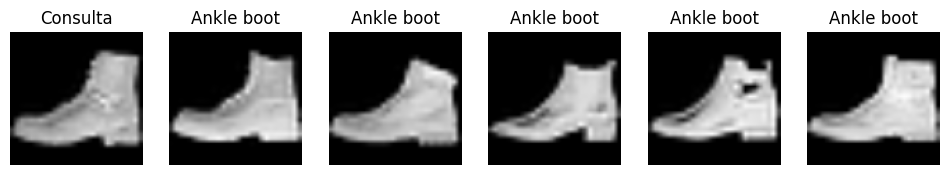

In [ ]:
# Pegar amostra aleatória
amostra = np.random.randint(0, all_images_for_display.shape[0])
print(f"Imagem de consulta aleatória (índice {amostra}) e recomendações semelhantes:")
recomendar(all_images_for_display[amostra])